# Gas Price Prediction with Recurrent Neural Networks (Daily, Window 2)

This notebook contains the generic RNN model used in the thesis project. The experiment includes two extracted datasets of a predefined gas station. The first dataset contains the daily maximum prices, while the other contains data of hourly granularity. The datasets are tested with basic recurrent, LSTM and GRU neurons. Extensive grid-search has been performed to build a set of different models. The following excerpt displays the different settings. <br>  <br> 

**Excerpt of experiment settings (Thesis):**
> [...] For this reason, the **hidden layer size (4, 8 or 12 neurons)** and the window size were modifed in a systematic way. Modifying the number of hidden neurons helps in determining a suitable architecture of the network. Different **window sizes (1, 2, 3, 7)** represent the number of input neurons. Furthermore, the various window sizes should test the dataset for different long or short-term dependencies. [...] The number of **training iterations** were **50, 100 and 200** for the daily dataset and **10, 25, 50** for the hourly dataset.

<br> 
Main parts of this notebook are adapted from **[2]**.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler


%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

# Model Building

## 1. Data Loading

In the following example, a preprocessed gas price dataset is used. The data contains the hourly prices in the period from 06-2014 - 05-2016. The dataset has been extracted from **[1]**.

In [2]:
gas_price = pd.read_csv("../Data/First_station_daily_maximum.csv", sep=";")

In [3]:
gas_price.head()

,max_date,stid,max
0,2014-06-08,105307c4-8562-45e4-9cc2-a04ef4a19400,152
1,2014-06-09,105307c4-8562-45e4-9cc2-a04ef4a19400,163
2,2014-06-10,105307c4-8562-45e4-9cc2-a04ef4a19400,164
3,2014-06-11,105307c4-8562-45e4-9cc2-a04ef4a19400,164
4,2014-06-12,105307c4-8562-45e4-9cc2-a04ef4a19400,165


In [4]:
data_to_use = gas_price['max'].values

## 2. Data Preprocessing
At this step, the input data gets scaled. Scaling supports model training. The following figure shows the scaled data.
In addtition to that, the dataset gets windowed. With sliding windows, squences of different length can be fed to the network for network tuning. Predictions are made based on theses sequences. By appling windowing, the original dataset gets shorten by a few observations.

#### Step 2.1: Data Scaling

In [5]:
scaler = StandardScaler()

In [6]:
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))

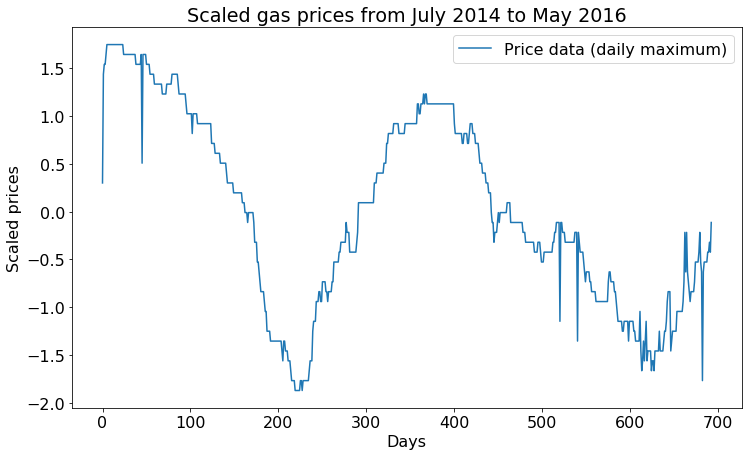

In [7]:
plt.figure(figsize=(12,7), frameon=False, edgecolor='blue')
plt.title('Scaled gas prices from July 2014 to May 2016')
plt.xlabel('Days')
plt.ylabel('Scaled prices')
plt.plot(scaled_data, label='Price data (daily maximum)')
plt.legend()
plt.show()

In [8]:
gas_price = gas_price.drop('stid', axis=1)

#### Step 2.2: Windowing the dataset
In order to modify the widow size, the window_size parameter must be changed here **and** in the hyperparameter section. (see Step 3)

In [9]:
def window_data(data, window_size):
    
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

In [10]:
X, y = window_data(scaled_data, 2)

#### Step 2.3 Train/test splitting
The windowed dataset gets divided into 80/20 (%)

In [11]:
split = int(len(X) * 0.8)
X_train  = np.array(X[:split])
y_train = np.array(y[:split])

X_test = np.array(X[split:])
y_test = np.array(y[split:])

In [12]:
print("X_train size: {}".format(len(X_train)))
print("y_train size: {}".format(len(X_test)))
print("X_test size: {}".format(len(y_train)))
print("y_test size: {}".format(len(y_test)))

X_train size: 552
y_train size: 139
X_test size: 552
y_test size: 139


In [13]:
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (552, 2, 1)
y_train size: (552, 1)
X_test size: (139, 2, 1)
y_test size: (139, 1)


## 3. Network Definition

#### Hyperparameter definition

In [14]:
#Hyperparameters to change
window_size = 2 
hidden_layer_size = 4
epochs = 200
number_of_layers = 1

#Fixed Hyperparameters
batch_size = 7
gradient_clip_margin = 4
learning_rate = 0.001
number_of_classes = 1


#### Output layer
For comparison of various networks, weight initialization is fixed. Therefore, the seed has been set to 2222.

In [15]:
def output_layer(lstm_output, in_size, out_size):
    
    x = lstm_output[:, -1, :]
    weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.05, seed=2222), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias')
    output = tf.matmul(x, weights) + bias
    return output

#### Loss and optimization
In this function, the gradients are computed, adam optimizer and gradient clipping are getting applied. Furthermore, the loss function gets minimized.

In [16]:
def opt_loss(logits, targets, learning_rate, grad_clip_margin):
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))])
        
        loss = tf.losses.mean_squared_error(targets, logits)
    
    #Clipping the gradients
    gradients = tf.gradients(loss, tf.trainable_variables())
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    return loss, train_optimizer

####  Build network
At this point, the entire network (computation graph) is built. To completely exclude randomness, the random seed gets also fixed on graph level. <br> <br>

In [17]:
tf.reset_default_graph()
tf.set_random_seed(1111)

#Inputs
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1], name='input_data')
targets = tf.placeholder(tf.float32, [batch_size, 1], name='targets')
drop_rate = tf.placeholder(tf.float32, name='drop_rate')

#Build Network
#
# Replace the following signature [GRUcell()] with:
#
# -> LSTMCell()       for LSTM
# -> BasicRNNCell()   for RNN
# -> GRUCell()        for GRU
# 
# The arguments remain unchanged.

lstm_cell = tf.nn.rnn_cell.GRUCell(hidden_layer_size, activation=tf.nn.elu) 
lstm_dropout = tf.contrib.rnn.DropoutWrapper(lstm_cell,input_keep_prob=drop_rate)
cell = tf.nn.rnn_cell.MultiRNNCell([lstm_dropout] * number_of_layers)

init_state = cell.zero_state(batch_size, tf.float32)


outputs, states = tf.nn.dynamic_rnn(cell, inputs, initial_state=init_state)

logits = output_layer(outputs, hidden_layer_size, number_of_classes)

loss, opt = opt_loss(logits, targets, learning_rate, gradient_clip_margin)

## 4. Network Training

In [18]:
session = tf.Session()

In [19]:
session.run(tf.global_variables_initializer())

#### 4.1. Model training
After building the tf-graph, it is now possible to train the network. In order to do that, the computation graph gets called by session_run(). Placeholder are fed with the feed_dict argument.

In [20]:
step=0
scores_per_epoch = []
loss_per_epoch = []
for i in range(epochs):
    trained_scores = []
    epoch_loss = []
    ii = 0

    while(ii + batch_size) <= len(X_train):
        
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([logits, loss, opt], feed_dict={inputs:X_batch, targets:y_batch, drop_rate:1})
       
        epoch_loss.append(c)
        trained_scores.append(o)
        ii += batch_size
        step += 1
    
    
    #training_metrics
    scores_per_epoch.append(trained_scores)
    loss_per_epoch.append(np.mean(epoch_loss))
    
    #Output to monitor progress       
    if (i % 20) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
    

Epoch 0/200  Current loss: 0.9738017320632935
Epoch 20/200  Current loss: 0.04124949499964714
Epoch 40/200  Current loss: 0.025894535705447197
Epoch 60/200  Current loss: 0.020169759169220924
Epoch 80/200  Current loss: 0.017707105726003647
Epoch 100/200  Current loss: 0.01656293496489525
Epoch 120/200  Current loss: 0.015671461820602417
Epoch 140/200  Current loss: 0.014867929741740227
Epoch 160/200  Current loss: 0.014241927303373814
Epoch 180/200  Current loss: 0.013755991123616695


#### 4.2. Plot of training score (loss per epoch)
As despicted in the figure, the network rapidly learns within the first few epochs. After that, the training performance is low.

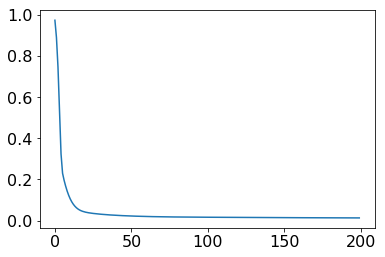

In [21]:
plt.figure()
plt.plot(loss_per_epoch, label='Original data')

##### 4.3. Collect training data
In this loop, the most recent predictions on the training set are collected for later use.

In [22]:
sup =[]
for i in range(len(trained_scores)):
    for j in range(len(trained_scores[i])):
        sup.append(trained_scores[i][j])

##### 4.4. Model Test
In the cell below, the model validation process is performed. It is possible to predict short-term price movements with the help of rolling forecasts. By doing so, test data is fed to the trained model. The forecast results (based on batch and window size) get stored in the list tests.

In [23]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    o = session.run([logits], feed_dict={inputs:X_test[i:i+batch_size], drop_rate:1.0})
    i += batch_size
    
    tests.append(o)

##### 4.5. Remove duplicate entries
The list tests contains multiple predictions for one observation due to batched mode. To get rid of these, the following operation is performed.

In [24]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

##### 4.6 Postprocess predictions
The cleansed list tests_new must be processed in order to plot the results correctly. For this reason, the predictions get inserted at the right index.

In [25]:
pos = (len(X_train))
size = len(X)-(batch_size-window_size+5) #must be adjusted for different window sizes!
test_results = []
for i in range(size):
    if i >= pos:
        test_results.append(tests_new[i-pos])
    else:
        test_results.append(None)

#### 4.7. Plot (scaled) results
The blue line shows the original data. The network seems to make good predictions. Due to batched mode, the last observations cannot be predicted.

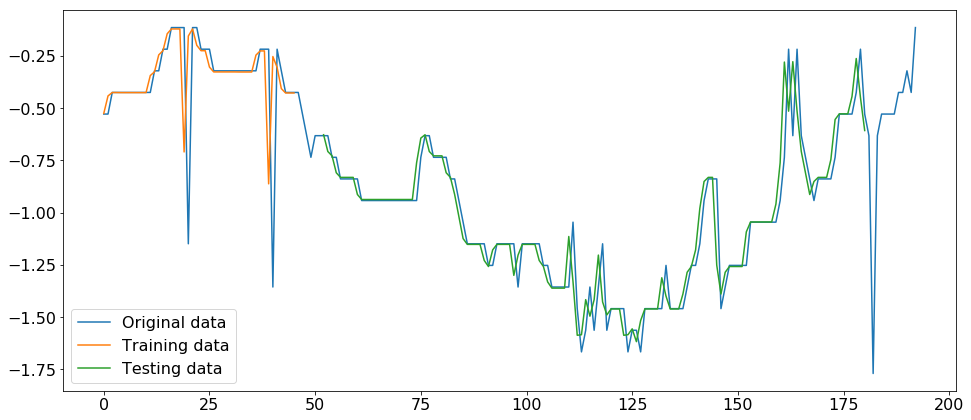

In [26]:
plt.figure(figsize=(16, 7))
plt.plot(scaled_data[500:], label='Original data')
plt.plot(sup[500:], label='Training data')
plt.plot(test_results[500:], label='Testing data')
plt.legend()
plt.show()


## 5. Analysis of Results

In [27]:
pred_rescaled = scaler.inverse_transform(tests_new, copy=None)

In [28]:
pred_rescaled_round = pred_rescaled.round()

#### 5.1. Plot rescaled results
The plot reveals that the network is able to predict the daily maximum with little deviations. The graphs are not as accurate as with window size 1. Apart from that, rounding the values leads to an increasing accuracy in flat periods, while there is a decreasing accuracy for spikes observable.

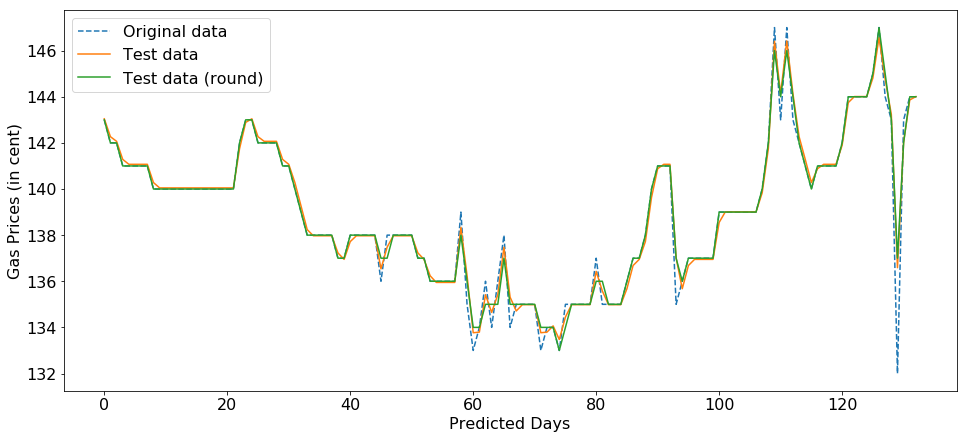

In [29]:
plt.figure(figsize=(16, 7))
plt.xlabel('Predicted Days')
plt.ylabel('Gas Prices (in cent)')
plt.plot(data_to_use[len(X_train)+1:len(X)-5], label='Original data', linestyle='--')
plt.plot(pred_rescaled, label='Test data')
plt.plot(pred_rescaled_round, label='Test data (round)')
plt.legend()
plt.show()

### Metrics

The following metrics are used:
+ Mean Absolute Error           **(MAE)**
+ Mean Squared Error            **(MSE)**
+ Root Mean Squared Error       **(RMSE)**
+ Mean Abs. Percentage Error    **(MAPE)**$*$
+ Mean Percentage Error         **(MPE)**

*$*$ Function **mean_absolute_percentage_error** has been adapted from **[3]**. **mean_percentage_error** is based on this.*

In [30]:
def mean_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean( y_true != y_pred ) *100

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
def print_metrics(prediction, rnd):
    
    start = len(X_train)+1
    end = len(X)-5 #must be adjusted for different window sizes!
    
    local_data = data_to_use[start:end] #Test-Set, extracted
    
    if rnd == True: #if rounded data is investigated
        
        #cast to int does not harm data as it is already rounded when passed to function; 
        #cast is not necessary, but performed for completeness.
        prediction = prediction.astype(np.int64) 
        prediction = prediction.reshape(local_data.shape)
        
    else:
        prediction = prediction.reshape(local_data.shape)
        local_data = local_data.astype(np.float64)
    
    mae  = metrics.mean_absolute_error(local_data, prediction)
    mse  = metrics.mean_squared_error(local_data, prediction)
    msle = metrics.mean_squared_log_error(local_data, prediction)
    mpe = mean_percentage_error(local_data, prediction)
    mape = mean_absolute_percentage_error(local_data, prediction)
    
    print("Mean Absolute Error: ", mae, sep="\t\t")
    print("Mean Squared Error: ", mse, sep="\t\t")
    print("Root Mean Squared Error: ", np.sqrt(mse), sep="\t")
    print("Mean Abs. Percentage Error: ", mape, sep="\t")
    print("Mean Percentage Error: ", mpe, sep="\t\t")

#### 5.2. Print metrics

In [33]:
print_metrics(pred_rescaled, False)

Mean Absolute Error: 		0.2587099003612547
Mean Squared Error: 		0.30565962432428523
Root Mean Squared Error: 	0.5528649241218737
Mean Abs. Percentage Error: 	0.18807303807843415
Mean Percentage Error: 		100.0


In [34]:
print_metrics(pred_rescaled_round, True)

Mean Absolute Error: 		0.20300751879699247
Mean Squared Error: 		0.3684210526315789
Root Mean Squared Error: 	0.6069769786668839
Mean Abs. Percentage Error: 	0.14846074546267765
Mean Percentage Error: 		16.541353383458645


In [35]:
session.close()

##### Dataset:

[1] Martin Kurz. *Historische Preisdaten*. 2017. Retrieved from https://creativecommons.tankerkoenig.de/ and licensed under CC-BY 4.0.

##### References:

[2] Luka Anicin. *tensorflow_lstm.ipynb*. 2017. URL: https://github.com/lucko515/tesla-stocks-prediction/blob/master/lstm_from_scratch_tensorflow.ipynb. *(visited on 02/28/2018)*

[3] Antonín Hoskovec. *Mean absolute percentage error (MAPE) in Scikit-learn*. 2017. URL: https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn/294069#294069 (visited on 02/28/2018)